In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)

In [12]:
# Загрузка данных
dataset = pd.read_csv('bank-full-marketing.csv', sep=';')

# Выбираем нужные столбцы
selected_columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
dataset = dataset[selected_columns]

# Разделение на обучающую, валидационную и тестовую выборки
training_set, temp_set = train_test_split(dataset, test_size=0.4, random_state=1)
validation_set, testing_set = train_test_split(temp_set, test_size=0.5, random_state=1)

print(f"Training set size: {training_set.shape}")
print(f"Validation set size: {validation_set.shape}")
print(f"Test set size: {testing_set.shape}")

Training set size: (27126, 15)
Validation set size: (9042, 15)
Test set size: (9043, 15)


In [13]:
# Анализ AUC для числовых признаков
numeric_features = ['balance', 'day', 'duration', 'previous']
area_under_curve = {}

for feature in numeric_features:
    auc = roc_auc_score(training_set['y'], training_set[feature])
    # Инвертируем признак, если AUC < 0.5
    if auc < 0.5:
        auc = roc_auc_score(training_set['y'], -training_set[feature])
    area_under_curve[feature] = auc

print("AUC for numerical features:", area_under_curve)

AUC for numerical features: {'balance': np.float64(0.5916931412945473), 'day': np.float64(0.5291275984648961), 'duration': np.float64(0.8128648066681694), 'previous': np.float64(0.5986704105715122)}


In [14]:
# Преобразование данных с помощью DictVectorizer
vectorizer = DictVectorizer(sparse=False)
X_training = vectorizer.fit_transform(training_set.drop(columns='y').to_dict(orient='records'))
X_validation = vectorizer.transform(validation_set.drop(columns='y').to_dict(orient='records'))

# Преобразование целевой переменной в числовой формат
label_encoder = LabelEncoder()
y_training = label_encoder.fit_transform(training_set['y'])
y_validation = label_encoder.transform(validation_set['y'])

# Обучение логистической регрессии
classifier = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
classifier.fit(X_training, y_training)

# Расчет AUC на валидационной выборке
y_predicted_proba = classifier.predict_proba(X_validation)[:, 1]
validation_auc = roc_auc_score(y_validation, y_predicted_proba)
print(f"Validation AUC: {validation_auc:.3f}")

Validation AUC: 0.900


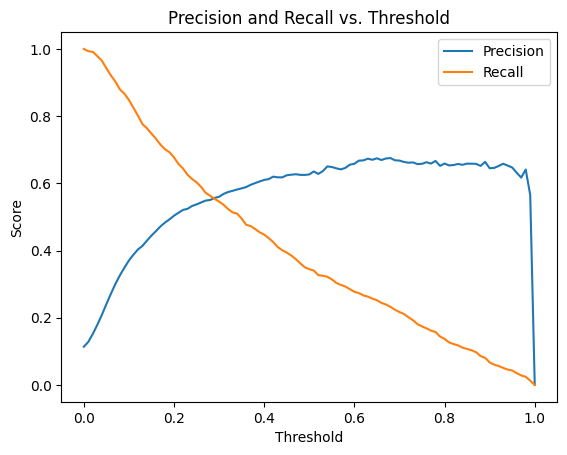

Threshold where Precision and Recall cross: 1.00
Best F1 score threshold: 0.20


In [15]:
# Вычисление Precision и Recall для разных порогов
threshold_values = np.linspace(0, 1, 101)  # Использование np.linspace вместо np.arange
precision_results = []
recall_results = []

for threshold in threshold_values:
    y_predicted_threshold = (y_predicted_proba >= threshold).astype(int)
    precision_results.append(precision_score(y_validation, y_predicted_threshold, zero_division=0)) # Обработка деления на ноль
    recall_results.append(recall_score(y_validation, y_predicted_threshold))

plt.plot(threshold_values, precision_results, label='Precision')
plt.plot(threshold_values, recall_results, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision and Recall vs. Threshold')
plt.show()

# Нахождение порога пересечения Precision и Recall
intersection_threshold = threshold_values[np.argmin(np.abs(np.array(precision_results) - np.array(recall_results)))]
print(f"Threshold where Precision and Recall cross: {intersection_threshold:.2f}")

# Нахождение наилучшего порога для F1 score
f1_scores = [f1_score(y_validation, (y_predicted_proba >= t).astype(int)) for t in threshold_values]
best_f1_threshold = threshold_values[np.argmax(f1_scores)]
print(f"Best F1 score threshold: {best_f1_threshold:.2f}")

In [16]:
# Кросс-валидация для подбора гиперпараметра C
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
C_options = [0.000001, 0.001, 1]
optimal_C = None
optimal_auc_avg = 0

for C in C_options:
    fold_aucs = []
    classifier = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    for train_indices, val_indices in kfold.split(X_training):
        X_train_fold, X_val_fold = X_training[train_indices], X_training[val_indices]
        y_train_fold, y_val_fold = y_training[train_indices], y_training[val_indices]
        
        classifier.fit(X_train_fold, y_train_fold)
        y_pred_fold = classifier.predict_proba(X_val_fold)[:, 1]
        fold_aucs.append(roc_auc_score(y_val_fold, y_pred_fold))
    
    mean_auc_fold = np.mean(fold_aucs)
    std_auc_fold = np.std(fold_aucs)
    
    print(f"C={C} - Mean AUC: {mean_auc_fold:.3f}, Std: {std_auc_fold:.3f}")
    
    if mean_auc_fold > optimal_auc_avg:
        optimal_C = C
        optimal_auc_avg = mean_auc_fold

print(f"Optimal C value: {optimal_C}")

C=1e-06 - Mean AUC: 0.696, Std: 0.008
C=0.001 - Mean AUC: 0.854, Std: 0.006
C=1 - Mean AUC: 0.908, Std: 0.004
Optimal C value: 1
